# EXPLORING NASA’S TURBOFAN DATASET
<hr>

## Exploratory Data Analysis and Hyper Parameter Tuning for FD003
## Introduction

This notebook contains an exploratory data analysis and evaluation of the some various types of machine learning models.<br>
Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
1. Engine unit number
2. Time, in cycles
3. Three operational settings
4. 21 sensor readings

Note: There are 4 datasets available of increasing complexity:  
Data Set FD003 is the third in the series.  
Train trjectories: 100  
Test trajectories: 100  
Conditions: ONE (Sea Level)  
Fault Modes: TWO (High Pressure Compressor(HPC) Degradation, Fan Degradation)`

### Importing libraries and Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Reading Data

In [2]:
# define filepath and files to read data
dir_path = './CMaps/'
train_file = 'train_FD003.txt'
test_file = 'test_FD003.txt'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD003.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

# check shape and inspect first few rows
print(train.shape)
train.head()

(24720, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [3]:
# inspect time cycles
train[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,100.00000
mean,247.20000
std,86.48384
min,145.00000
25%,189.75000
50%,220.50000
75%,279.75000
max,525.00000


In [4]:
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,24720.0,518.670000,6.684921e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,24720.0,642.457858,5.230311e-01,640.8400,642.0800,642.4000,642.7900,645.1100
s_3,24720.0,1588.079175,6.810418e+00,1564.3000,1583.2800,1587.5200,1592.4125,1615.3900
s_4,24720.0,1404.471212,9.773178e+00,1377.0600,1397.1875,1402.9100,1410.6000,1441.1600
s_5,24720.0,14.620000,3.602525e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,24720.0,21.595841,1.811600e-02,21.4500,21.5800,21.6000,21.6100,21.6100
s_7,24720.0,555.143808,3.437343e+00,549.6100,553.1100,554.0500,556.0400,570.4900
s_8,24720.0,2388.071555,1.582849e-01,2386.9000,2388.0000,2388.0700,2388.1400,2388.6000
s_9,24720.0,9064.110809,1.998029e+01,9017.9800,9051.9200,9060.0100,9070.0925,9234.3500
s_10,24720.0,1.301232,3.484849e-03,1.2900,1.3000,1.3000,1.3000,1.3200


Judging by the standard deviation of (almost) zero, sensors 1, 5, 16, 18 and 19 hold no valuable information.

## Computing RUL

In [5]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,258
1,1,2,257
2,1,3,256
3,1,4,255
4,1,5,254


## Data Visualization

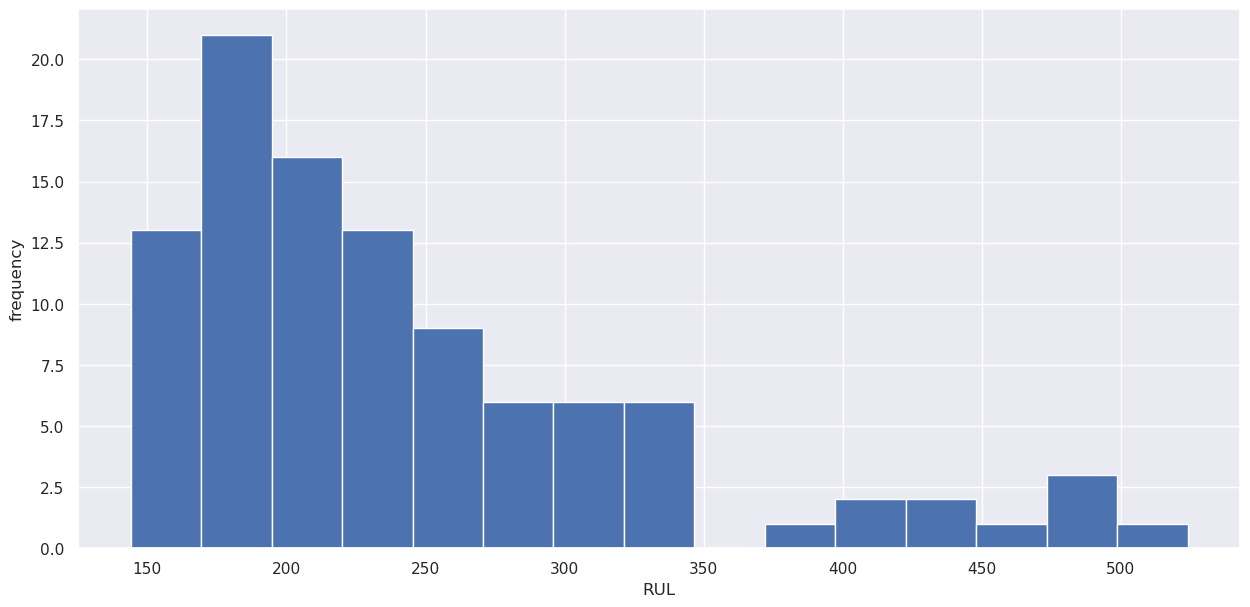

In [6]:
# visualizing remaining useful life
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

The data is right skewed and this can have a huge impact on the model

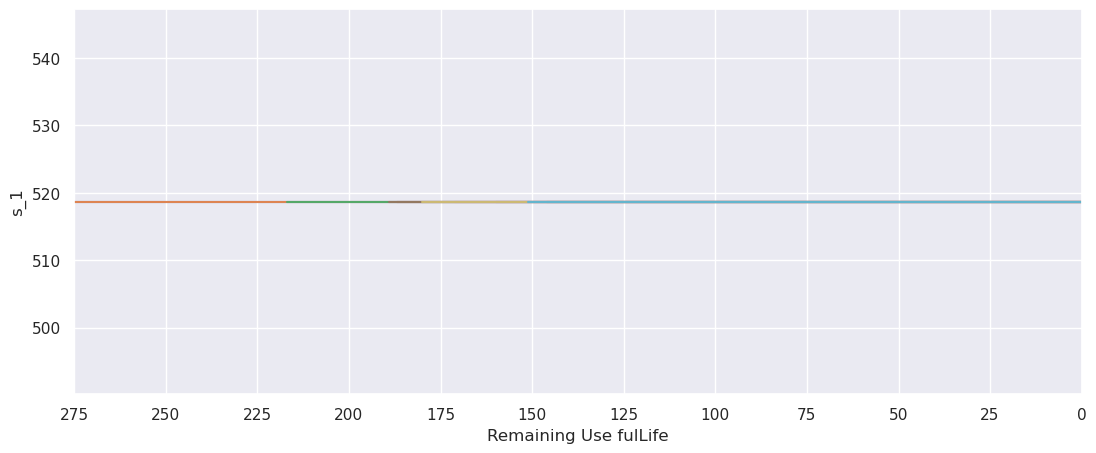

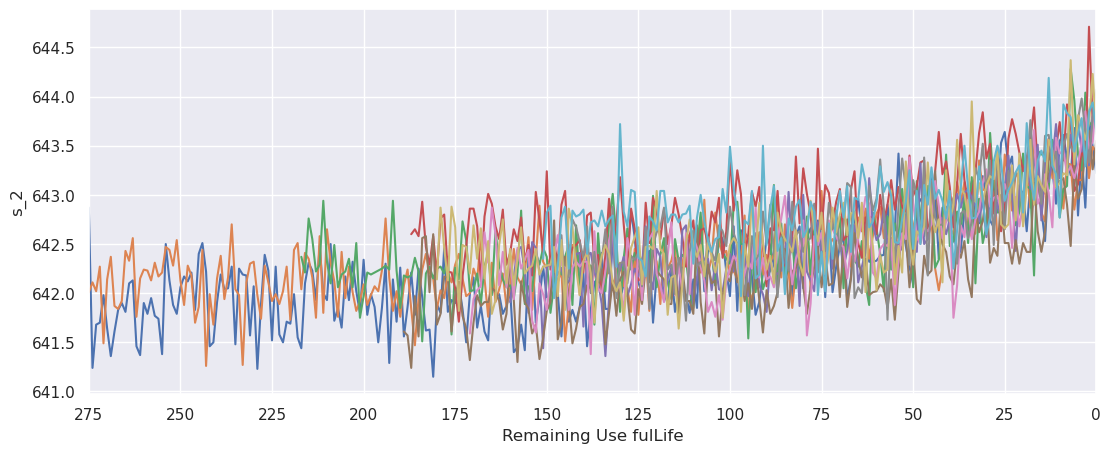

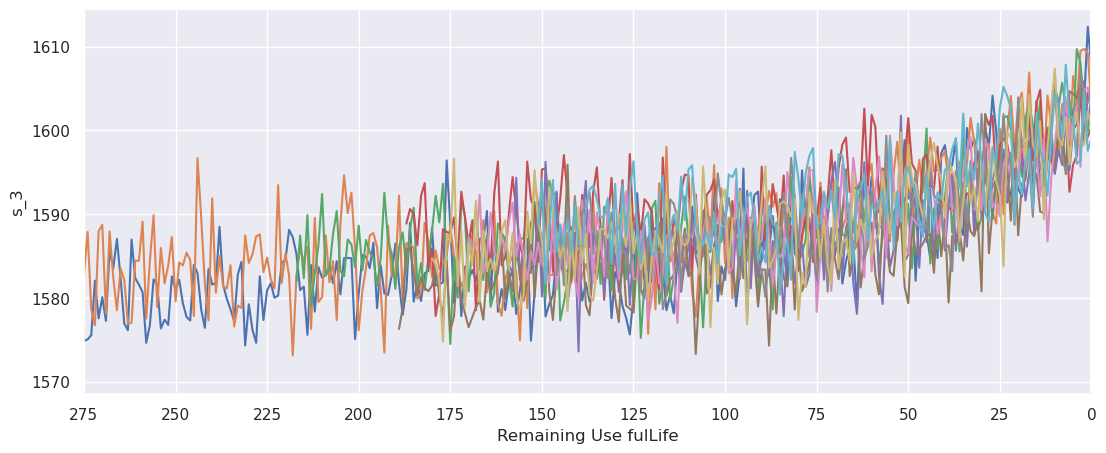

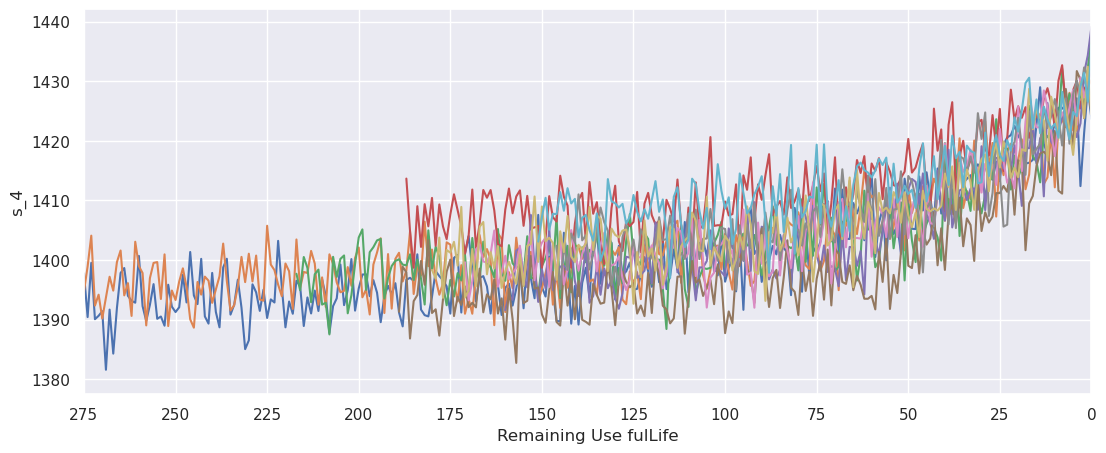

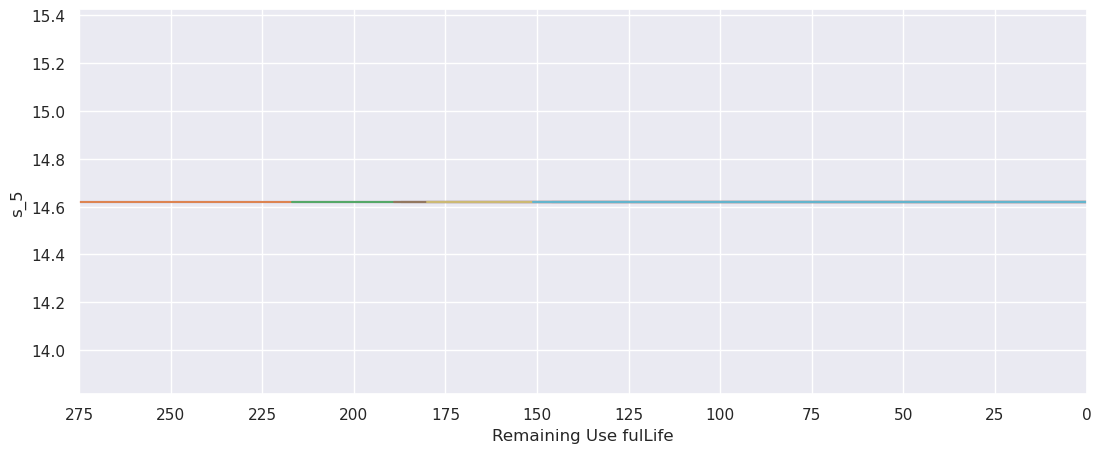

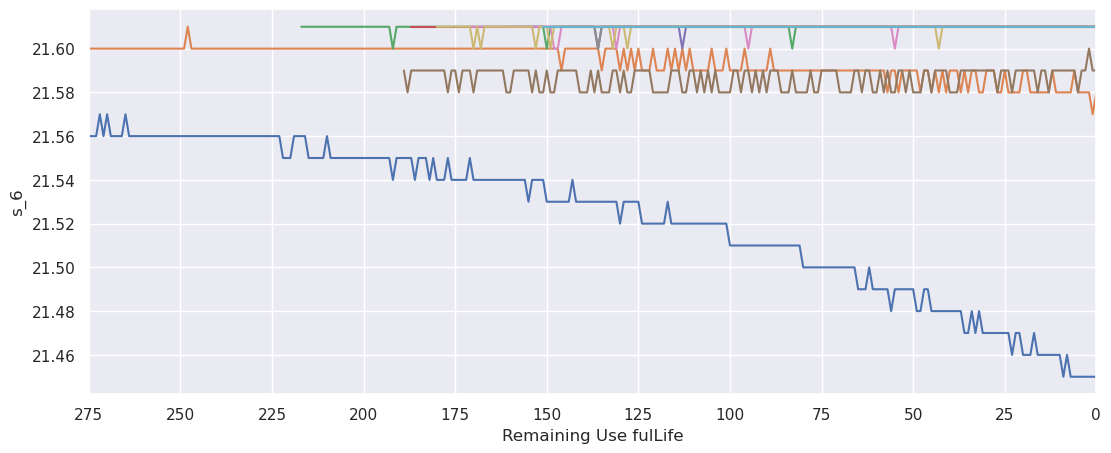

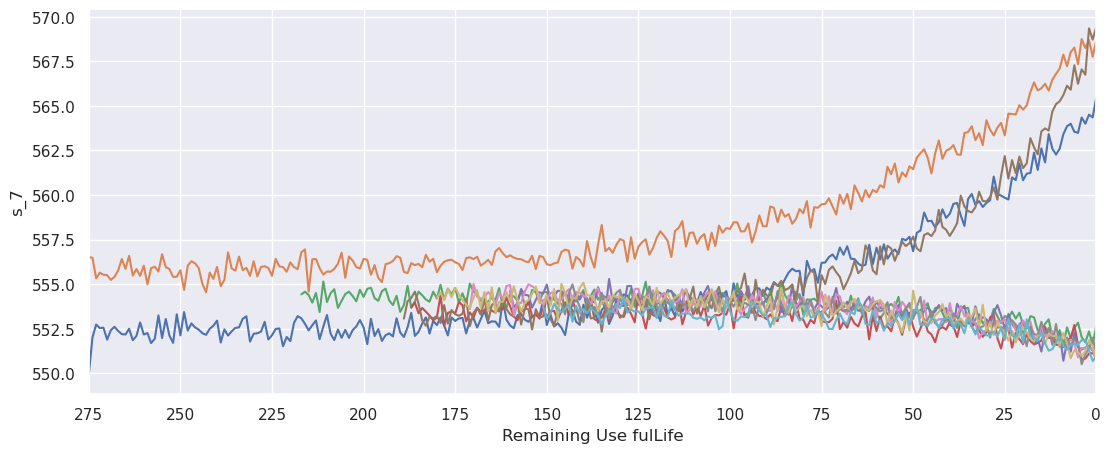

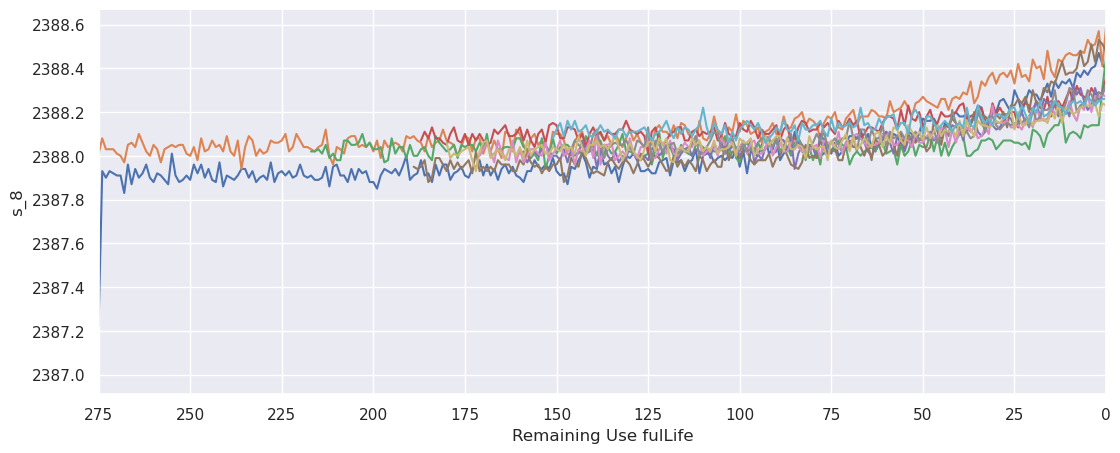

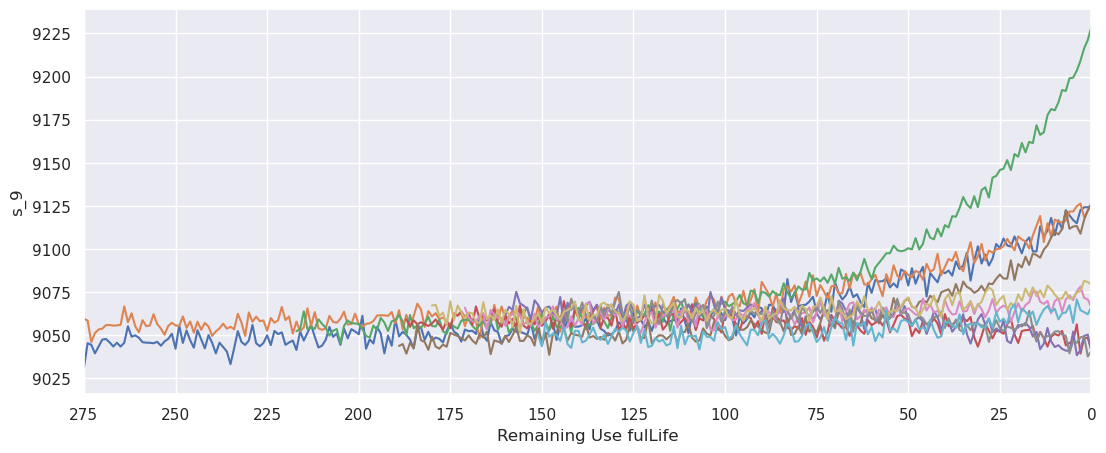

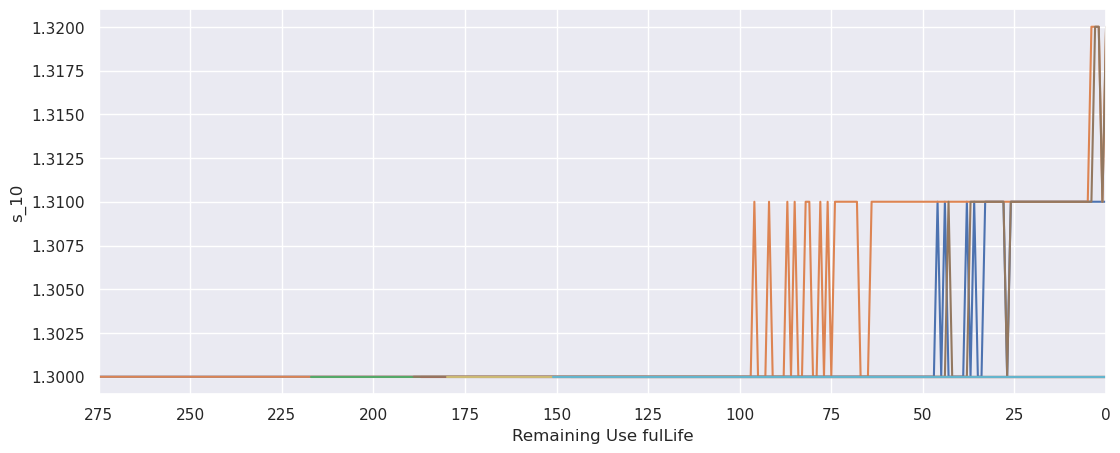

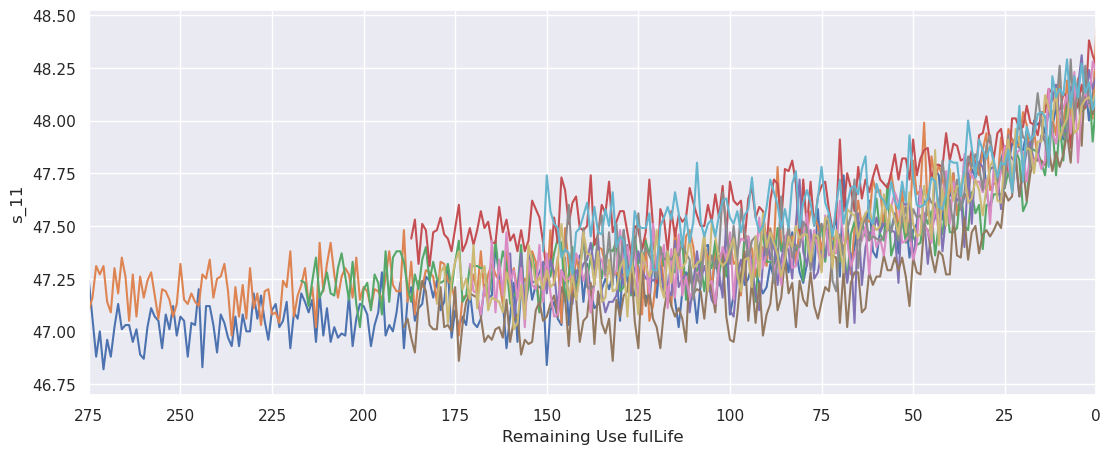

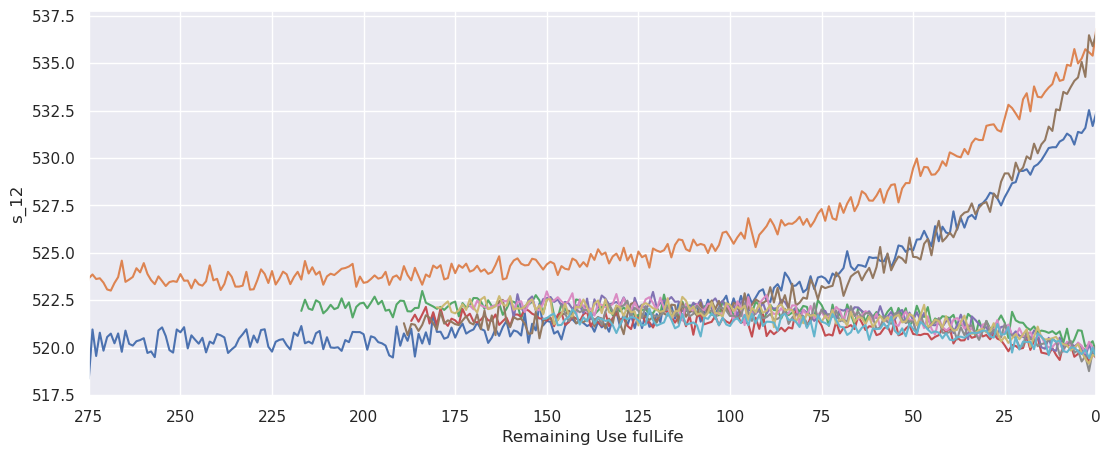

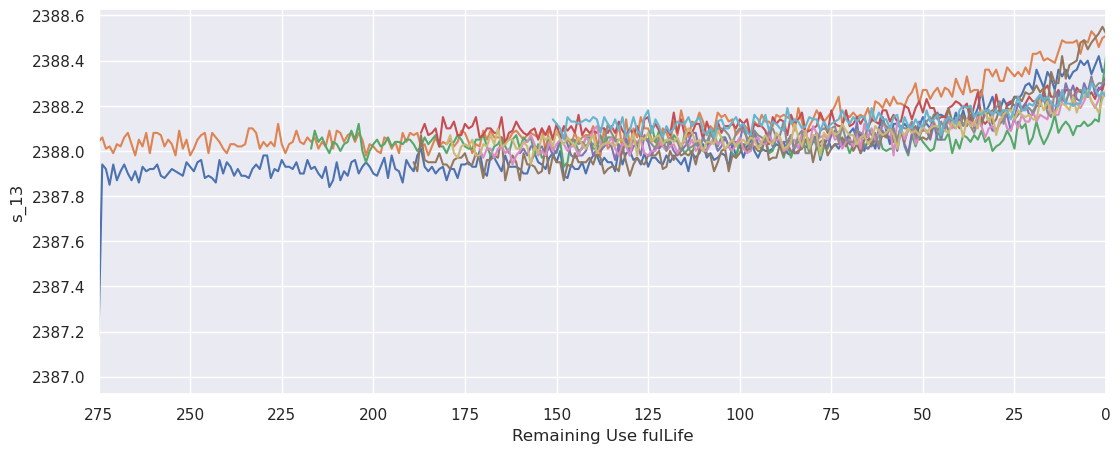

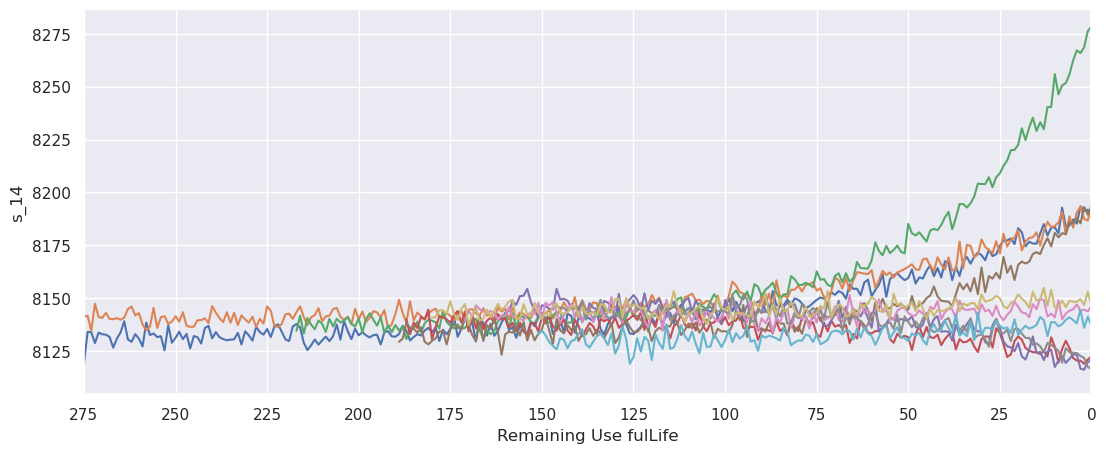

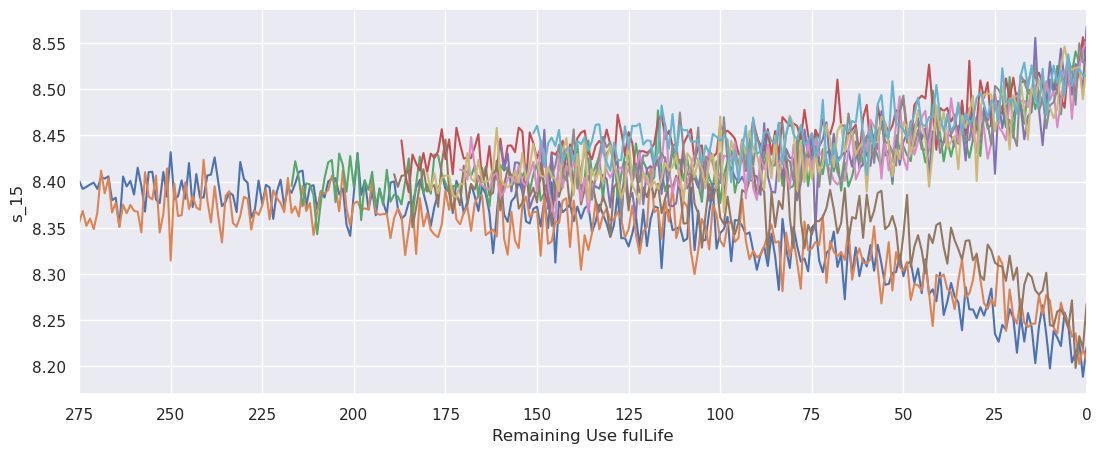

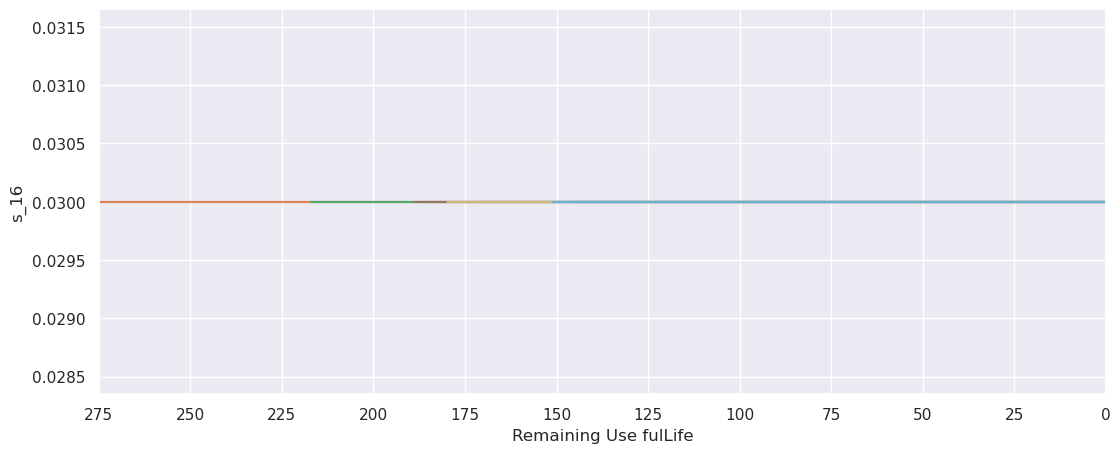

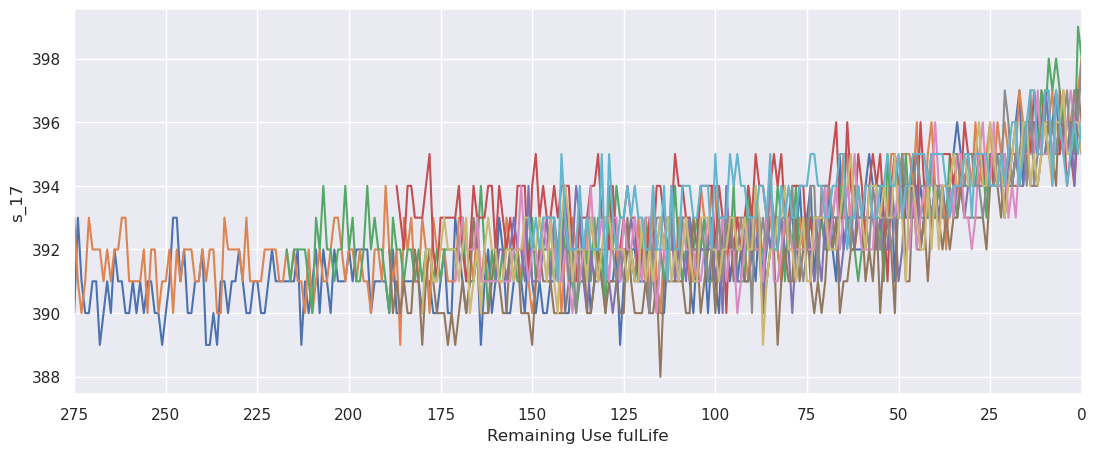

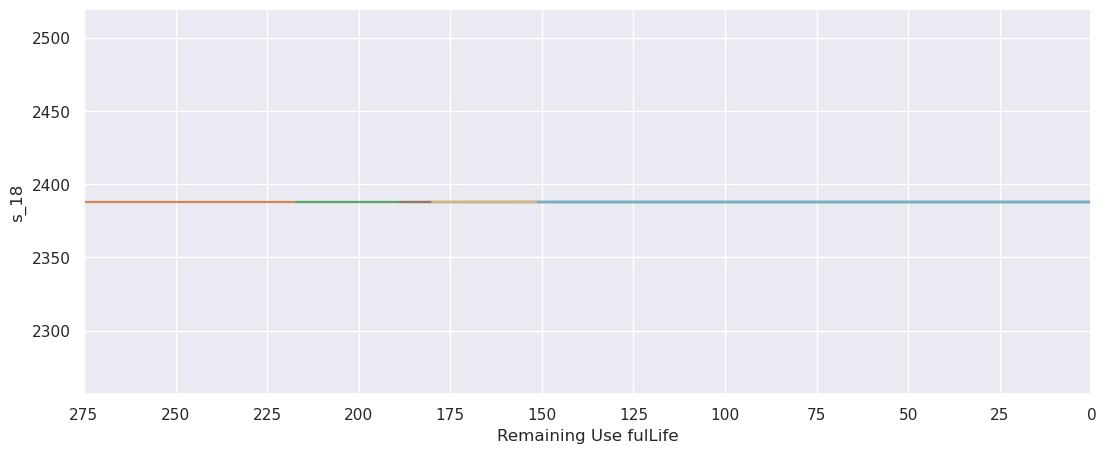

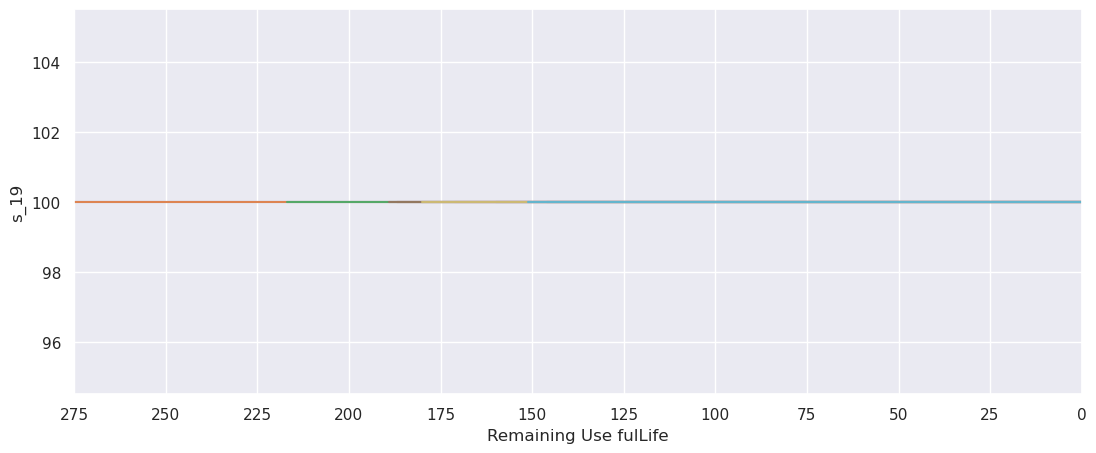

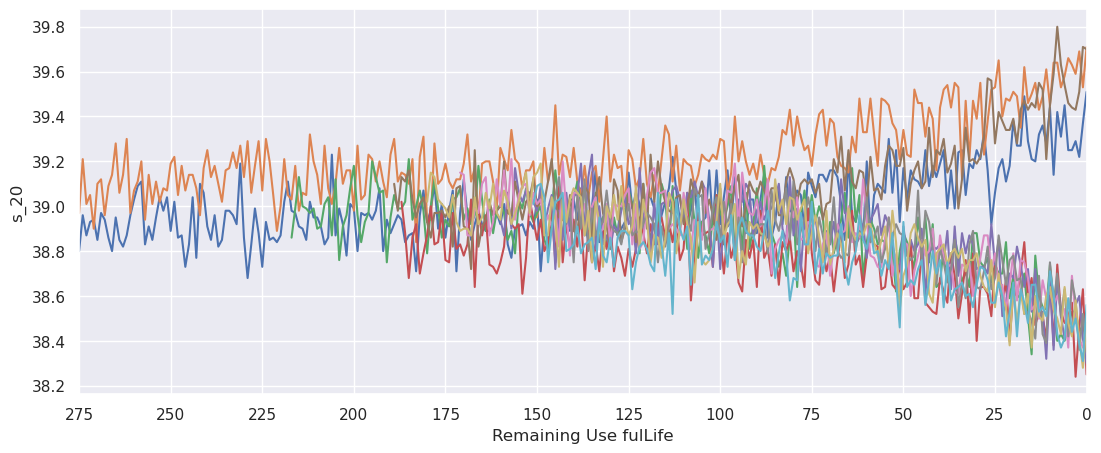

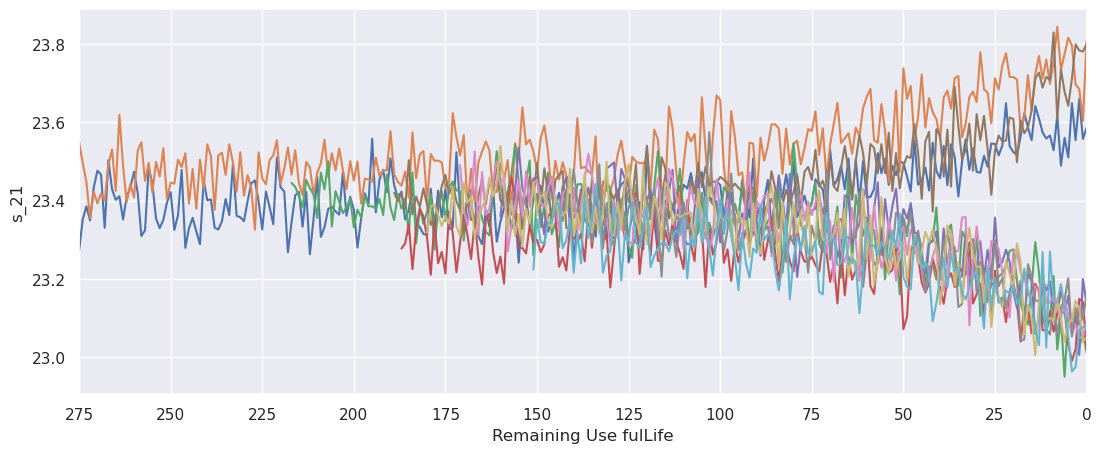

In [7]:
# plotting sensors
def plot_signal(df, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_nr'].unique():
        if (i % 10 == 0):  
            plt.plot('RUL', signal_name, 
                     data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor in sensor_names:
    plot_signal(train, sensor)

- As it can be seen, sensors 1, 5, 16, 18 and 19 holds no valuable information and can be dropped from the dataset
- Sensors 2, 3, 4, 8, 11, 13 and 17 shows similar upward trend and must be included in the model
- Sensors 7, 12, 15, 20 and 21 clearly show the two fault mode and also must be included in the model
- Sensors 9 and 14 show similar trends 

## Splitting Data 

In [8]:
# drop unwanted columns and split target variable from training set
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']  # s_6 and s_10 get the benefit of the doubt
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)  # apply RUL clipping from earlier posts

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [9]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

## Linear Regression (Baseline Model)

In [10]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:19.33013490506061, R2:0.7736110804777467
test set RMSE:22.31934448440365, R2:0.7092939799790338


Setting the RSME of 22.32 approx. as the baseline for the models yet to be trained

## Random Forest Regression 

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:

# create and train model
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:5.9199939580022525, R2:0.9787661901585051
test set RMSE:21.05308450085165, R2:0.7413439613827657


In [13]:
print(rf.estimators_[5].tree_.max_depth)
print(rf.estimators_[5].tree_.n_node_samples)

33
[15616 11694  7793 ...     1     1     4]


This tree’s longest path consists of 33 set of nodes, more than double the number of features we put in. When looking at the `n_nodes_samples`, we can see the final leaves of the tree contain very few samples each.It can be seen clearly that the Randorm Forest Model without tuning overfitted the data. 

## Tuning Ranform Forest Model

The parameters `max_depth`, `min_samples_leaf`, `ccp_alpha` and `min_impurity_decrease` help reduce overfitting and generate overall better performing model.<br>
Initially, I will set the max-depth and min_samples_leaf to see how the model performs and after use RandomSearchCV to the RandomForestRegressor to get the best model perfomance. 

In [14]:
rf = RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_leaf=50, max_features="sqrt", random_state=42)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:15.706704198492831, R2:0.8505294865338602
test set RMSE:20.994958823842456, R2:0.7427702419664686


In [15]:
max_depth = [None] + list(range(3, 34, 3)) 
min_samples_leaf = list(range(1, 102, 10))  
min_impurity_decrease = list(np.arange(0,147)/10)  
ccp_alpha = list(np.round(np.linspace(0, 2, 81), decimals=3))  

parameters = {
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,
    'ccp_alpha': ccp_alpha
}

In [23]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

ITERATIONS = 300

rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
gkf = GroupKFold(n_splits=3)  # prevents data leakages


regressor = RandomizedSearchCV(rf, 
                               param_distributions=parameters, cv= gkf.split(train, groups=train['unit_nr']),
                               error_score='raise', n_iter=ITERATIONS,
                               scoring= 'neg_root_mean_squared_error')  
regressor.fit(X_train, y_train_clipped)  # train model

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f038e2737d0>,
                   error_score='raise',
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   random_state=42),
                   n_iter=300,
                   param_distributions={'ccp_alpha': [0.0, 0.025, 0.05, 0.075,
                                                      0.1, 0.125, 0.15, 0.175,
                                                      0.2, 0.225, 0.25, 0.275,
                                                      0.3, 0.325, 0.35, 0.375,
                                                      0.4, 0.425, 0.45, 0.475,
                                                      0.5, 0.525, 0.55, 0.575,
                                                      0.6, 0.625, 0.65, 0.675,
                                                      0.7, 0.725, ...],
                                        'max_depth': [None, 3, 6, 9, 12, 15, 18,
     

In [25]:
regressor.best_estimator_

RandomForestRegressor(ccp_alpha=0.275, max_depth=24, max_features='sqrt',
                      min_impurity_decrease=0.1, min_samples_leaf=31,
                      random_state=42)

In [26]:
rf = RandomForestRegressor(ccp_alpha=0.275, max_depth=24, max_features='sqrt',
                      min_impurity_decrease=0.1, min_samples_leaf=31,
                      random_state=42)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:15.195904253084056, R2:0.8600933061925038
test set RMSE:20.81944172403486, R2:0.7470531274667498
